# Publishing Figures - Multi Kappa
This notebook is for generating extratropic specific plots, combining all $\kappa$ simulations.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p, g, R
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.adiabat_theory import (get_delta_temp_quant_theory, get_delta_mse_mod_anom_theory,
                                              get_delta_temp_quant_theory_simple, decompose_temp_adiabat_anomaly)
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-04-23 17:05:31,974 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'sphum', 'height', 'convflag', 'klzbs']
# var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


In [3]:
# Sigma levels
np.convolve(namelist['vert_coordinate_nml']['bk'], np.ones(2)/2, 'valid')

array([0.00588325, 0.0157172 , 0.02559615, 0.04003275, 0.06023775,
       0.08735865, 0.1223205 , 0.16566145, 0.21739335, 0.2769161 ,
       0.3430068 , 0.4138911 , 0.4873889 , 0.5611121 , 0.6326847 ,
       0.6999534 , 0.7611607 , 0.8150635 , 0.8609897 , 0.898836  ,
       0.92901895, 0.95239485, 0.9701652 , 0.9837833 , 0.99487445])

## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [66]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 8/8 [00:50<00:00,  6.30s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [67]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mod_mean = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
z_mean = np.zeros((n_exp, n_lat))

# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_mod_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
mse_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting
with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.isel(pfull=ind_ft).mean(dim='lon_time')
        mse_mod = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], height=0, c_p_const=c_p - lnp_const)
        mse_mod_mean[i] = mse_mod.mean(dim='lon_time')
        mse = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], ds_all[i].height[ind_surf])
        mse_mean[i] = mse.mean(dim='lon_time')
        # For surface temperature, take actual quantile - rather than average over quantile days
        temp_quant3[i, ind_surf] = ds_all[i].temp[ind_surf].quantile(quantiles_all/100, dim='lon_time').transpose()
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3[i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, k, j] = ds_all[i].height.isel(pfull=ind_ft)[k, use_ind].mean()
                mse_mod_quant3[i, k, j] = mse_mod[k, use_ind].mean(dim='lon_time')
                mse_quant3[i, k, j] = mse[k, use_ind].mean(dim='lon_time')
                temp_quant3[i, ind_ft, k, j] = ds_all[i].temp[ind_ft, k, use_ind].mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

100%|██████████| 14256/14256 [01:06<00:00, 213.34it/s]


## Convective days as function of $x$ for each $\kappa$
We expect the amount of days convecting to increase with surface temperature. Below, we see that this assumption breaks down for the hottest simulations.

A day is convecting if `convflag>1` (at least shallow convection) and $LNB<486hPa$. The percentage of days that satisfy this is shown in the second plot below.

In [68]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds[0].pfull)), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

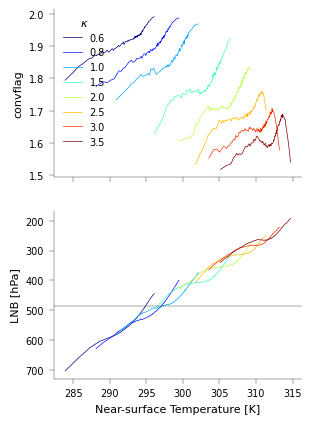

In [69]:
colors_exp = plt.cm.jet(np.linspace(0, 1, n_exp))
save_convflag_fig = False
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2 * width['one_col'] / ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights),
               np.average(convflag_quant3[i], axis=0, weights=lat_weights), color=colors_exp[i], label=f'{tau_lw[i]}')
    ax[1].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights),
               lzb(np.average(klzbs_quant3[i], axis=0, weights=lat_weights)), color=colors_exp[i])
ax[1].axhline(pressure_ft_actual/100, color='k', lw=ax_linewidth)
ax[0].legend(title='$\kappa$')
ax[0].set_ylabel('convflag')
ax[-1].set_xlabel('Near-surface Temperature [K]')
ax[1].invert_yaxis()
ax[1].set_ylabel('LNB [hPa]')
# ax.set_ylim(1, 2)
if save_convflag_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convflag_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

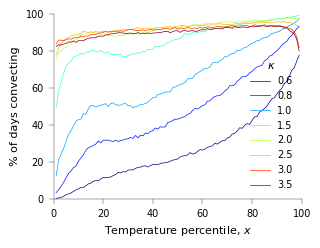

In [70]:
save_convfract_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar), sharex=True)
for i in range(n_exp):
    ax.plot(quantiles_all, 100 * np.average(convfract_quant3[i], axis=0, weights=lat_weights),
            color=colors_exp[i], label=f'{tau_lw[i]}')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_ylabel('% of days convecting')
ax.legend(title='$\kappa$')
if save_convfract_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convfract_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [71]:
def get_gradient(temp_quant, temp_av, ref_ind, confidence = 0.9):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient
        [n_exp]
            Predicted temperature for each experiment
        float
            Confidence value for the gradient, such that there is the desired confidence 
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return param, fit_func(temp_av, param), z_score * param_std

## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

In [72]:
quant_grad_plot = [1, 25, 50, 75, 99]
quant_grad_plot_ind = numpy_indexed.indices(quantiles_all, quant_grad_plot)
n_quant_grad_plot = len(quant_grad_plot)

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
temp_quant_grad = np.zeros((n_lat, n_quant_grad_plot))
temp_quant_grad_fit = np.zeros((n_exp, n_lat, n_quant_grad_plot))
for i in range(n_lat):
    for j in range(n_quant_grad_plot):
        temp_quant_grad[i, j], temp_quant_grad_fit[:, i, j], _ = \
            get_gradient(temp_quant3[:, ind_surf, i, quant_grad_plot_ind[j]], temp_mean[:, ind_surf, i], tau_ref_ind)

Gradient of best fit line for [1, 25, 50, 75, 99] percentiles: [1.13 0.99 0.99 0.99 0.98]


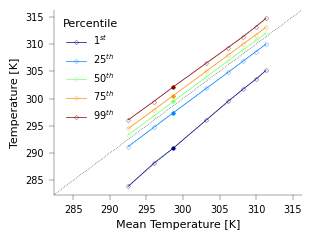

In [73]:
trend_line_on = True
save_trend_fig = False

color_seq_quant = plt.cm.jet(np.linspace(0,1,n_quant_grad_plot))

# labels_quant = [f'{qu}$^{st}$', '25$^{th}$', '50$^{th}$', '75$^{th}$', '99$^{th}$']
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for j in range(n_quant_grad_plot):
    ax.plot(np.average(temp_mean[:, ind_surf], weights=lat_weights, axis=1),
            np.average(temp_quant3[:, ind_surf, :, quant_grad_plot_ind[j]], weights=lat_weights, axis=1),
            marker='o',
            label=f'{quant_grad_plot[j]}'+ ('$^{st}$' if quant_grad_plot[j]==1 else '$^{th}$'),
            color=color_seq_quant[j], fillstyle='none')
    if trend_line_on:
        # Filled circle for reference simulation
        ax.plot(np.average(temp_mean[:, ind_surf], weights=lat_weights, axis=1)[tau_ref_ind],
                np.average(temp_quant3[:, ind_surf, :, quant_grad_plot_ind[j]], weights=lat_weights, axis=1)[tau_ref_ind],
                marker='o', color=color_seq_quant[j], fillstyle='full')
        if j==n_quant_grad_plot-1:
            label = None #'Linear fits'
        else:
            label = None
        ax.plot(np.average(temp_mean[:, ind_surf], weights=lat_weights, axis=1),
                np.average(temp_quant_grad_fit[:, :, j], axis=1, weights=lat_weights),
                linestyle='--', color=color_seq_quant[j], alpha=0.3, label=label)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim_new = [np.asarray([xlim, ylim]).min(), np.asarray([xlim, ylim]).max()]
ax.plot(lim_new, lim_new, 'k:', alpha=0.75)
ax.set_ylim(lim_new)
ax.set_xlim(lim_new)
if trend_line_on:
    ax.legend(loc='upper left', title='Percentile')
ax.set_xlabel(f'Mean Temperature [K]')
ax.set_ylabel(f'Temperature [K]')
if save_fig or save_trend_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight',
                pad_inches=save_pad_inches)
print(f'Gradient of best fit line for {quant_grad_plot} percentiles: {np.round(np.average(temp_quant_grad, weights=lat_weights, axis=0), 2)}')

## Scaling Factor
Below I combine all simulations to get a scaling factor for temperature covering all simulations. I get both the simulated and theoretical scaling factors.

In [74]:
# delta_temp_quant_theory[-1] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant_theory = {method: np.zeros((n_exp, n_lat, n_quant_all)) for method in
                           ['wtg', 'z', 'wtg_no_rh', 'z_no_rh', 'old', 'old_no_rh', 'best', 'best_no_rh']}
with tqdm(total=(n_exp-1)*n_lat*(len(delta_temp_quant_theory) - 2), position=0, leave=True) as pbar:
    for i in range(n_exp-1):
        for j in range(n_lat):
            for key in delta_temp_quant_theory:
                if 'old' in key:
                    continue
                if 'best' in key:
                    delta_temp_quant_theory[key][i:i+2, j] = \
                        get_delta_temp_quant_theory(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], sphum_mean[i:i+2, j], 
                                                    sphum_quant3[i:i+2, j], p_surface, pressure_ft_actual, None, None, None, None, 'squared', 'squared', 
                                                    'none' if 'no_rh' in key else 'full')[0]
                else:
                    if 'z' in key:
                        delta_temp_quant_theory[key][i:i+2, j] = \
                            get_delta_temp_quant_theory_simple(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], sphum_mean[i:i+2, j],
                                                               sphum_quant3[i:i+2, j], p_surface, pressure_ft_actual, temp_mean[i:i+2, ind_ft, j],
                                                               temp_quant3[i:i+2, ind_ft, j], z_mean[i:i+2, j], z_quant3[i:i+2, j], 
                                                               ignore_rh=True if 'no_rh' in key else False)[0]
                    elif 'wtg' in key:
                        delta_temp_quant_theory[key][i:i+2, j], delta_temp_quant_theory[key.replace('wtg', 'old')][i:i+2, j], _, _ = \
                            get_delta_temp_quant_theory_simple(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], sphum_mean[i:i+2, j],
                                                               sphum_quant3[i:i+2, j], p_surface, pressure_ft_actual, 
                                                               ignore_rh=True if 'no_rh' in key else False)
                pbar.update(1)

# theory3 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory3 = {method: temp_quant3.copy() for method in delta_temp_quant_theory}
for method in delta_temp_quant_theory:
    for j in range(n_exp-1):
        temp_quant_theory3[method][1+j] = temp_quant_theory3[method][j] + delta_temp_quant_theory[method][j]

100%|██████████| 756/756 [00:20<00:00, 36.23it/s]


In [75]:
confidence = 0.9        # desired confidence for shading in plots
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [tau_lw_ref, tau_lw_ref, tau_lw_ref]
n_sf = len(sf_tau_use)
sf_tau_ref_ind = [np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0] for i in range(n_sf)]
sf_labels = ['All $\kappa$', f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$', f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_sf, n_lat, n_quant_all))
scaling_factor_error = np.zeros((n_sf, n_lat, n_quant_all))

scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_temp_quant_theory}

sf_av = temp_mean[:, ind_surf]

for i in range(n_sf):
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            scaling_factor[i, k, j], _, scaling_factor_error[i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j],
                                                                                     sf_av[sf_tau_use[i], k], sf_tau_ref_ind[i],
                                                                                     confidence)
            for method in scaling_factor_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                scaling_factor_theory[method][i, k, j] = get_gradient(temp_quant_theory3[method][sf_tau_use[i], ind_surf, k, j],
                                                           sf_av[sf_tau_use[i], k],
                                                           sf_tau_ref_ind[i], confidence)[0]

## Simulated Scaling Factor
Combine simulations to plot the simulated warming of a given percentile as a function of the mean warming.

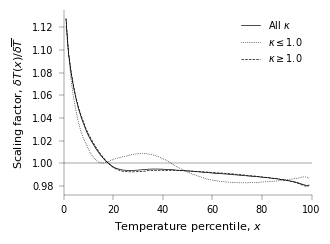

In [76]:
save_sf_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='k', label=sf_labels[0])
ax.plot(quantiles_all, np.average(scaling_factor[1], axis=0, weights=lat_weights), color='k', linestyle=':',
        label = sf_labels[1])
ax.plot(quantiles_all, np.average(scaling_factor[2], axis=0, weights=lat_weights), color='k', linestyle='--',
        label = sf_labels[2])
ax.hlines(1, 0, 100, lw=ax_linewidth, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(1)
# ax.lines.pop(1)
ax.legend()
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_multi_kappa_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['monochrome'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### Tropical Theory
Below I apply the theory developed for the tropics to the extratropics. It predicts the amplified warming of cold days, but is not quantitatively accurate.

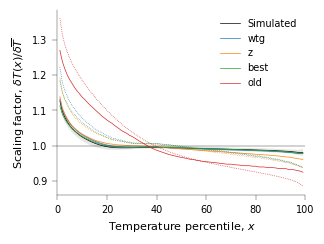

In [77]:
# Do a single plot combining all simulations
sf_ind_use = 0  # 0, 1 or 2
save_sf_theory_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quantiles_all, np.average(scaling_factor[sf_ind_use], axis=0, weights=lat_weights), color='k', label='Simulated')
for i, key in enumerate(['wtg', 'z', 'best', 'old']):
    ax.plot(quantiles_all, np.average(scaling_factor_theory[key][sf_ind_use], axis=0, weights=lat_weights), color=default_colors[i], 
            label=key)
    ax.plot(quantiles_all, np.average(scaling_factor_theory[key+'_no_rh'][sf_ind_use], axis=0, weights=lat_weights), color=default_colors[i],
            linestyle=':')
# Add error
ax.fill_between(quantiles_all, np.average(scaling_factor[sf_ind_use]-scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), 
                np.average(scaling_factor[sf_ind_use]+scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), fc='k', alpha=0.1)
ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend()
ax.set_xlim(0,100)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

In [78]:
lambda_p = {var: np.zeros((n_sf, n_lat, n_quant_all)) for var in ['temp', 'sphum', 'mse_mod', 'mse']}
lambda_p_mse_mod_error = np.zeros((n_sf, n_lat, n_quant_all))

for i in range(n_sf):
    for j in range(n_quant_all):
        # Straight line through the ref point
        for k in range(n_lat):
            lambda_p['temp'][i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j], temp_mean[sf_tau_use[i], ind_surf, k], 
                                                     sf_tau_ref_ind[i], confidence)[0]
            lambda_p['sphum'][i, k, j] = get_gradient(sphum_quant3[sf_tau_use[i], k, j], sphum_mean[sf_tau_use[i], k], sf_tau_ref_ind[i],
                                                      confidence)[0]
            lambda_p['mse_mod'][i, k, j], _, lambda_p_mse_mod_error[i, k, j] = get_gradient(mse_mod_quant3[sf_tau_use[i], k, j], 
                                                                                    mse_mod_mean[sf_tau_use[i], k], sf_tau_ref_ind[i], confidence)
            lambda_p['mse'][i, k, j], _, lambda_p_mse_mod_error[i, k, j] = get_gradient(mse_quant3[sf_tau_use[i], k, j], 
                                                                                        mse_mean[sf_tau_use[i], k], sf_tau_ref_ind[i], confidence)

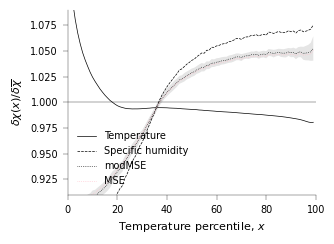

In [79]:
save_lambda_fig = False
fig_include_mse_raw = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels = ['Temperature','Specific humidity', 'modMSE']
linestyles = ['-', '--', ':']
for j, var in enumerate(['temp', 'sphum', 'mse_mod']):
    ax.plot(quantiles_all, np.average(lambda_p[var][sf_ind_use], axis=0, weights=lat_weights), label=labels[j], linestyle=linestyles[j],
               color='k')
if fig_include_mse_raw:
    ax.plot(quantiles_all, np.average(lambda_p['mse'][sf_ind_use], axis=0, weights=lat_weights), linestyle=':', color='pink', label='MSE')
ax.fill_between(quantiles_all, np.average(lambda_p['mse_mod'][sf_ind_use]-lambda_p_mse_mod_error[sf_ind_use], axis=0, weights=lat_weights), 
                np.average(lambda_p['mse_mod'][sf_ind_use]+lambda_p_mse_mod_error[sf_ind_use], axis=0, weights=lat_weights), fc='k', alpha=0.1)
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.legend(loc='lower left')
ax.set_xlabel(percentile_label)
ax.set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
ax.set_ylim(0.91,1.09)
ax.set_xlim(0, 100)
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda$ Decomposition
The tropical theory assumes that $\lambda = \delta h(x)/\delta \overline{h} \approx 1$. Below, I split $\lambda$ into three variables linking free troposphere and surface to see why this is no longer the case in the extratropics.

The decomposition shows different things for hot and cold simulations.

In [80]:
# delta_mse_mod_ratio = np.diff(mse_mod_quant3, axis=0)/np.expand_dims(np.diff(mse_mod_mean, axis=0), axis=-1)
delta_mse_mod_anom_theory = {'linear': np.zeros((n_exp-1, n_lat, n_quant_all)), 'squared': np.zeros((n_exp-1, n_lat, n_quant_all))}
for i in range(n_exp-1):
    for j in range(n_lat):
        for key in delta_mse_mod_anom_theory:
            delta_mse_mod_anom_theory[key][i, j] = get_delta_mse_mod_anom_theory(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], 
                                                                           sphum_mean[i:i+2, j], sphum_quant3[i:i+2, j], p_surface, pressure_ft_actual, 
                                                                           taylor_terms=key)[0]
mse_mod_anom = mse_mod_quant3 - mse_mod_mean[:, :, np.newaxis]
# theory3 adds the same theoretical delta_h_anom to theory prediction of previous kappa so errors accumulate
mse_mod_anom_theory3 = {method: mse_mod_anom.copy() for method in delta_mse_mod_anom_theory}
for key in delta_mse_mod_anom_theory:
    for i in range(n_exp-1):
        mse_mod_anom_theory3[key][i+1] = mse_mod_anom_theory3[key][i] + delta_mse_mod_anom_theory[key][i]

In [81]:
mse_mod_anom_sf = np.zeros((n_sf, n_lat, n_quant_all))

mse_mod_anom_sf_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_mse_mod_anom_theory}

mse_mod_anom_sf_av = mse_mod_mean

for i in range(n_sf):
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            mse_mod_anom_sf[i, k, j] = get_gradient(mse_mod_anom[sf_tau_use[i], k, j], mse_mod_mean[sf_tau_use[i], k], sf_tau_ref_ind[i],
                                                    confidence)[0]
            for key in mse_mod_anom_sf_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                mse_mod_anom_sf_theory[key][i, k, j] = get_gradient(mse_mod_anom_theory3[key][sf_tau_use[i], k, j],
                                                           mse_mod_mean[sf_tau_use[i], k],
                                                           sf_tau_ref_ind[i], confidence)[0]

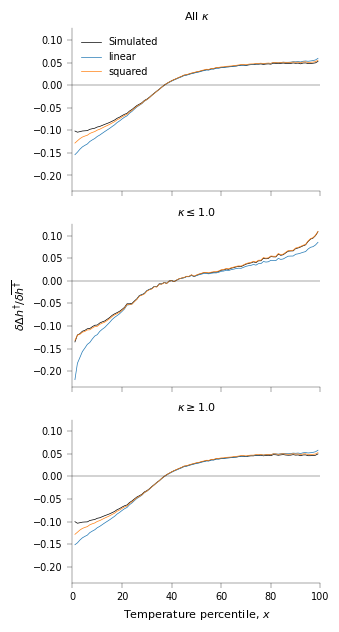

In [82]:
save_lambda_decomp_all_sf_fig = False
fig, ax = plt.subplots(n_sf,1, figsize=(width['one_col'], n_sf*width['one_col']/ar), sharex=True, sharey=True)
for k in range(n_sf):
    ax[k].plot(quantiles_all, np.average(mse_mod_anom_sf[k], axis=0, weights=lat_weights), color='k', label='Simulated')
    for i, key in enumerate(mse_mod_anom_sf_theory):
        ax[k].plot(quantiles_all, np.average(mse_mod_anom_sf_theory[key][k], axis=0, weights=lat_weights), color=default_colors[i], label=key)
    ax[k].axhline(0, color='k', lw=ax_linewidth)
    ax[k].set_title(sf_labels[k])
ax[0].legend()
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel(percentile_label)
ax[1].set_ylabel('$\delta \Delta h^{\dagger} / \delta \overline{h^{\dagger}}$')
# ax.set_xlabel(f"{'Temperature percentile' if quant3_method=='temp' else 'Moist static energy percentile'}, $x$")
# ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_all_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anomaly_all_sf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $T_{FT}$ Standard Deviation
For tropics, expect standard deviation of $T_{FT}$ to be small. Below, I check if this is the case for all simulations, and how it changes with latitude.

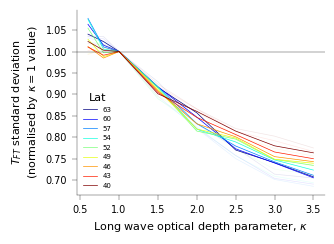

In [83]:
temp_ft_std_dev = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    temp_ft_std_dev[i] = ds_all[i].temp[ind_ft].std(dim='lon_time')

save_temp_ft_std_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
color_seq_lat = plt.cm.jet(np.linspace(0,1,int(n_lat/2)))
for i in range(int(n_lat/2)):
    ax.plot(tau_lw, temp_ft_std_dev[:, -(i+1)]/temp_ft_std_dev[sf_tau_ref_ind[0], -(i+1)], color=color_seq_lat[i], 
             label=round(float(ds_all[0].lat[-(i+1)])))
    ax.plot(tau_lw, temp_ft_std_dev[:, i]/temp_ft_std_dev[sf_tau_ref_ind[0], i], color=color_seq_lat[i], alpha=0.1)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.legend(title='Lat', fontsize=5)
ax.set_xlabel('Long wave optical depth parameter, $\kappa$')
ax.set_ylabel('$T_{FT}$ standard deviation\n(normalised by $\kappa=1$ value)')

if save_fig or save_temp_ft_std_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_ft_std_lat_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Probability Density Function
#### Tropics
Below, I plot how the temperature distribution relative to the median changes with warming. Clearly, the coldest days become closer to the median as optical depth increases (blue $\rightarrow$ red). The hottest days also become closer to the median as optical depth increases for the lower optical depths. But for the hottest simulations, as the optical depth increases, the hottest days become hotter.
#### Extratropics
In the extratropics, the narrowing of the seasonal cycle (hottest days get cooler and coldest days get warmer relative to the median) with warming is much more apparent.

#### Standard Deviation
The third plot shows the standard deviation as a function of longwave optical depth, relative to the $\kappa=1$ simulation. This shows that the shape of the distribution stays more constant for MSE than temperature.

#### Coefficient of Variation
The faint lines show the coefficient of variation (standard deviation divided by mean). This shows more that the distribution stays more constant for MSE. The key point is that mean MSE increases more than mean temperature does with warming. So the deviation relative to the mean stays more constant for MSE.

In [84]:
hist_norm_by_mean = True               # Do histogram of anomaly divided by mean rather than raw anomaly
if region == 'extratropics':
    n_hist_bins = 33*3
    hist_bins_lims_temp = [-33, 33]
elif region == 'tropics':
    n_hist_bins = 15*15
    hist_bins_lims_temp = [-8, 8]
else:
    n_hist_bins = 49*3
    hist_bins_lims_temp = [-49, 49]
if hist_norm_by_mean:
    hist_bins_lims_temp = [-0.025, 0.025]
temp_hist_counts = np.zeros((n_exp, n_lat, n_hist_bins))
temp_std_dev = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    for j in range(n_lat):
        hist_var_use = ds_all[i].temp[ind_surf, j]- ds_all[i].temp[ind_surf, j].mean()
        if hist_norm_by_mean:
            hist_var_use = hist_var_use / ds_all[i].temp[ind_surf, j].mean()
        temp_hist_counts[i, j] = np.histogram(hist_var_use, n_hist_bins, hist_bins_lims_temp)[0]
        temp_std_dev[i, j] = ds_all[i].temp[ind_surf, j].std()
temp_coef_var = temp_std_dev / temp_mean[:, ind_surf]
hist_bins = np.histogram(hist_var_use, n_hist_bins, hist_bins_lims_temp)[1]
hist_bin_centres_temp = moving_average(hist_bins, 2)

temp_hist_weight = np.average(temp_hist_counts, weights=lat_weights, axis=1)
temp_hist_weight = temp_hist_weight/np.sum(temp_hist_weight, axis=1, keepdims=True)

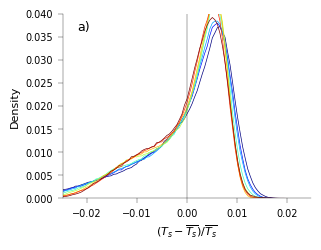

In [85]:
save_pdf_fig = False
plot_log = False
color_seq_exp = plt.cm.jet(np.linspace(0,1,n_exp))
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(hist_bin_centres_temp, temp_hist_weight[i], color=color_seq_exp[i], label=f'{tau_lw[i]}')
if hist_norm_by_mean:
    ax.set_xlabel('$(T_s-\overline{T_s})/\overline{T_s}$')
else:
    ax.set_xlabel('$T_s-\overline{T_s}$ [K]')
ax.set_ylabel('Density')
if plot_log:
    ax.set_yscale('log')
    ax.set_ylim(10**-5, temp_hist_weight.max())
else:
    ax.set_ylim(0, temp_hist_weight.max())
ax.set_ylim(0, 0.04)
ylim = ax.get_ylim()
ax.vlines(0, ylim[0], ylim[1], lw=ax_linewidth, colors='k')
ax.set_xlim(hist_bin_centres_temp[0], hist_bin_centres_temp[-1])
label_subplots(fig, ax)
if region == 'tropics':
    ax.legend(title='$\kappa$')
if save_fig or save_pdf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_pdf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [86]:
if hist_norm_by_mean:
    hist_bins_lims_mse = [-0.06, 0.06]
else:
    hist_bins_lims_mse = [-25, 25]
    hist_bins_lims_mse = np.asarray(hist_bins_lims_mse) * 1000/c_p      # convert units from kJ/kg into Kelvin
mse_hist_counts = np.zeros((n_exp, n_lat, n_hist_bins))
mse_std_dev = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    for j in range(n_lat):
        mse_use = moist_static_energy(ds_all[i].temp[ind_surf, j], ds_all[i].sphum[ind_surf, j], height=0, c_p_const=c_p - lnp_const)
        hist_var_use = mse_use-mse_use.mean()
        if hist_norm_by_mean:
            hist_var_use = hist_var_use / mse_use.mean()
        else:
            hist_var_use = 1000*hist_var_use / c_p        # convert units from kJ/kg into Kelvin
        mse_hist_counts[i, j] = np.histogram(hist_var_use, n_hist_bins, hist_bins_lims_mse)[0]
        mse_std_dev[i, j] = mse_use.std()
mse_coef_var = mse_std_dev / mse_mod_mean
hist_bins = np.histogram(hist_var_use, n_hist_bins, hist_bins_lims_mse)[1]
hist_bin_centres_mse = moving_average(hist_bins, 2)

mse_hist_weight = np.average(mse_hist_counts, weights=lat_weights, axis=1)
mse_hist_weight = mse_hist_weight/np.sum(mse_hist_weight, axis=1, keepdims=True)

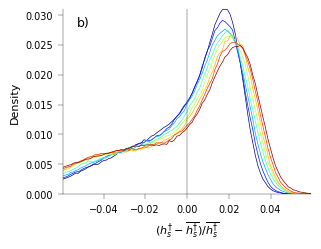

In [87]:
save_mse_pdf_fig = False
plot_log = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(hist_bin_centres_mse, mse_hist_weight[i], color=color_seq_exp[i], label=f'{tau_lw[i]}')
if hist_norm_by_mean:
    ax.set_xlabel('$(h_s^{\dagger}-\overline{h_s^{\dagger}})/\overline{h_s^{\dagger}}$')
else:
    ax.set_xlabel('$(h_s^{\dagger}-\overline{h_s^{\dagger}})/c_p$ [K]')
ax.set_ylabel('Density')
if plot_log:
    ax.set_yscale('log')
    ax.set_ylim(10**-5, mse_hist_weight.max())
else:
    ax.set_ylim(0, mse_hist_weight.max())
ylim = ax.get_ylim()
ax.vlines(0, ylim[0], ylim[1], lw=ax_linewidth, colors='k')
ax.set_xlim(hist_bin_centres_mse[0], hist_bin_centres_mse[-1])
label_subplots(fig, ax, ['b)'])


if save_fig or save_mse_pdf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_pdf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

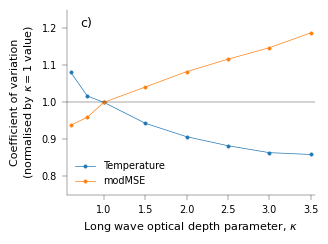

In [88]:
include_coef_var = True
save_std_dev_fig = False

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
if include_coef_var:
    ax.plot(tau_lw, np.average(temp_coef_var/temp_coef_var[sf_tau_ref_ind[0]], axis=1, weights=lat_weights), '-o',
        color=default_colors[0], label='Temperature')
    ax.plot(tau_lw, np.average(mse_coef_var/mse_coef_var[sf_tau_ref_ind[0]], axis=1, weights=lat_weights), '-o', 
        color=default_colors[1], label='modMSE')
else:
    ax.plot(tau_lw, np.average(temp_std_dev/temp_std_dev[sf_tau_ref_ind[0]], axis=1, weights=lat_weights), '-o', label='Temperature', 
            color=default_colors[0])
    ax.plot(tau_lw, np.average(mse_std_dev/mse_std_dev[sf_tau_ref_ind[0]], axis=1, weights=lat_weights), '-o', label='Modified moist static energy',
            color=default_colors[1])
ax.set_xlim(tau_lw[0]-0.05, tau_lw[-1]+0.05)
ax.set_ylim(0.75, 1.25)
xlim = ax.get_xlim()
ax.hlines(1, xlim[0], xlim[1], lw=ax_linewidth, colors='k')
label_subplots(fig, ax, ['c)'])
ax.legend(loc='lower left')
ax.set_xlabel('Long wave optical depth parameter, $\kappa$')
ax.set_ylabel('$\sigma/\sigma_{\kappa=1}$')
if include_coef_var:
    ax.set_ylabel('Coefficient of variation\n(normalised by $\kappa=1$ value)')
else:
    ax.set_ylabel('Standard deviation\n(normalised by $\kappa=1$ value)')

if save_fig or save_std_dev_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/std_dev_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Decomposition of Adiabatic Temperature Anomaly, $\Delta T_A$
Here I see how $T_{CE}(x)$ and $\Delta T_{FT}(x)$ vary with warming.

In [96]:
temp_adiabat_anom_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
temp_ce_mean = np.zeros((n_exp, n_lat))
temp_ce_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
temp_ft_anom_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_ft_anom_quant3 = z_quant3 - z_mean[:, :, np.newaxis]
for j in range(n_lat):
    temp_adiabat_anom_quant3[:, j], temp_ce_mean[:, j], temp_ce_quant3[:, j], temp_ft_anom_quant3[:, j] = \
        decompose_temp_adiabat_anomaly(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], sphum_quant3[:, j], 
                                       temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], p_surface, pressure_ft_actual)
temp_adiabat_anom_quant3_z_form = temp_ce_mean[:, :, np.newaxis] - temp_ce_quant3 + g/lnp_const * z_ft_anom_quant3

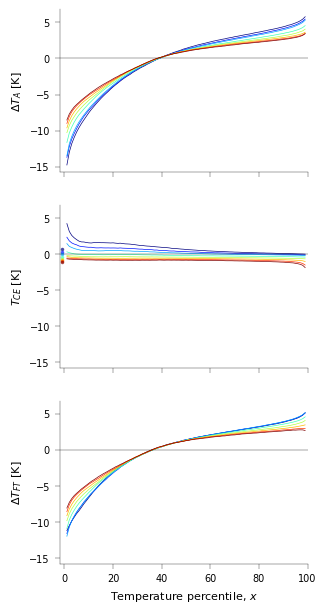

In [102]:
save_temp_adiabat_fig = False
use_temp_adiabat_z_form = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    if use_temp_adiabat_z_form:
        ax[0].plot(quantiles_all, np.average(temp_adiabat_anom_quant3_z_form[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
        ax[2].plot(quantiles_all, g/lnp_const * np.average(z_ft_anom_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
    else:
        ax[0].plot(quantiles_all, np.average(temp_adiabat_anom_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
        ax[2].plot(quantiles_all, np.average(temp_ft_anom_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
    ax[1].plot(quantiles_all, np.average(temp_ce_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
    ax[1].scatter(-1, np.average(temp_ce_mean[i], axis=0, weights=lat_weights), marker='o', alpha=0.7, edgecolors=None,
                  facecolors=color_seq_exp[i], lw=0)
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(-2, 100)
ax[1].set_ylabel('$T_{CE}$ [K]')
if use_temp_adiabat_z_form:
    ax[0].set_ylabel("$\Delta T_A'$ [K]")
    ax[2].set_ylabel('$\\frac{g}{R^{\dagger}}\Delta z_{FT}$ [K]')
else:
    ax[0].set_ylabel('$\Delta T_A$ [K]')
    ax[2].set_ylabel('$\Delta T_{FT}$ [K]')
ax[-1].set_xlabel(percentile_label)

if save_fig or save_temp_adiabat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_adiabat_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)